# Прогнозирование с помощью машинного обучения количества обращений за медицинской помощью. Описание проекта.

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год.

Доступны 2 выборки:

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Для оценки качества модели будет применяться метрика MSE.

# Загрузка данных.

Загружаем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

!pip install catboost
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


Фиксируем переменные.

In [2]:
RNDM_STATE = 42 # перееменная для Random State

Пишем необходимые дальнейшем функции.

In [3]:
# Функция для исследования датафреймов.

def df_info(df):

    print(df.info())
    print('')
    display(df.sample(10))
    print('')
    display(df.describe())
    print('')
    print(f'Количество явных дубликатов в датафрейме: {df.duplicated().sum()}.')
    print('')
    print('Процент пропусков по столбцам:')
    display(
        pd.DataFrame(round(df.isna().mean() * 100, 2)).style.background_gradient(
            'coolwarm'
        )
    )

# Функция для построения графиков медианного значения целевой переменной,
# сгруппированных по значениям входящих признаков.

def median_target_plot(feature):

    fig, axs = plt.subplots(1, 1, figsize=(7, 5))
    df_grouped = df_train.groupby(feature)['number_of_visits_23'].median()
    axs.bar(df_grouped.index, df_grouped.values, color='navy', alpha=0.6)
    axs.set_title(
        f'Медианное значение целевой переменной для признака {feature}'
    )
    axs.tick_params(axis='x', rotation=45)
    axs.grid(True)

# Функция для построения графиков ferature importance.

def feature_imp(model):
    feature_importance = model.get_feature_importance(prettified=True)
    sns.set(rc={'figure.figsize': (10, 7)})
    feature_importance.plot(
        x='Feature Id', y='Importances', kind='bar', color='navy', alpha=0.6
    )
    plt.xlabel('Параметры')
    plt.ylabel('Важность для модели')
    plt.title('Топ-3 параметров модели по важности')
    plt.xticks(rotation=45)
    plt.show()

Загружаем данные.

In [4]:
df_train = pd.read_excel(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Тестовое_1/ML_train.xlsx'
)
df_test = pd.read_excel(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Тестовое_1/ML_holdout.xlsx'
)

In [5]:
df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000 non-null  int64         
dtypes

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
25501,1461030,Network-2,Saudi,Male,Child,2006-10-31,NaN,0,365,0,0,365,1
707,1336391,Network-2,Saudi,Male,Child,2018-01-09,S61.7;D31;J02;J06.9;J02.0;R23.1;J06,1,365,7,19,365,2
47129,4413204,Network-2,Others,Male,Self,1945-01-01,E03.9;R06.0;E11;I25.9;I50.9;E78.5,0,77,2,21,365,6
48303,63045748,Network-2,Group 2,Male,Self,1974-01-10,E78.5;E78.2;E78,1,365,4,12,365,2
9216,1379358,Network-2,Saudi,Female,Child,2009-12-21,NaN,0,365,0,0,365,1
21579,1441644,Network-2,Saudi,Male,Child,2016-02-03,R23.1;J06.9;Y59.0,1,365,9,47,365,8
35406,1529729,Network-2,Saudi,Male,Self,1970-09-01,NaN,0,365,0,0,365,16
19153,1429031,Network-2,Saudi,Male,Self,1987-01-15,K21.0;H18.7,0,365,2,3,365,0
11508,1390957,Network-2,Saudi,Male,Child,2004-05-13,NaN,0,365,0,0,238,0
35913,1534151,Network-2,Saudi,Female,Spouse,1979-02-02,E78;K29.7,0,365,2,10,365,2


,Insured_PIN,DoB,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
count,5.000000e+04,49999,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.105307e+06,1990-02-22 19:50:30.036600704,0.337940,358.898960,5.740320,22.477420,355.588420,5.898860
min,7.491000e+03,1920-03-21 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000
25%,1.394020e+06,1971-03-23 00:00:00,0.000000,365.000000,1.000000,3.000000,365.000000,1.000000
50%,1.456638e+06,1991-11-13 00:00:00,0.000000,365.000000,4.000000,13.000000,365.000000,4.000000
75%,1.560591e+06,2011-04-17 00:00:00,1.000000,365.000000,8.000000,31.000000,365.000000,8.000000
max,9.100533e+07,2022-11-12 00:00:00,1.000000,365.000000,151.000000,962.000000,365.000000,202.000000
std,1.443978e+07,NaN,0.473013,35.562003,6.592556,29.714146,43.779065,6.856904



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
Insured_PIN,0.000000
Insured_Network,0.000000
Nationality,0.000000
Gender,0.000000
Relation,0.000000
DoB,0.000000
Diagnoses,17.550000
HasChronicDisease,0.000000
Exposition_22,0.000000
number_of_visits_22,0.000000


**Описание данных:**

- Insured_PIN - уникальный ид застрахованного лица
- Insured_Network - Идентификатор сети клиник доступной для застрахованного. Network - 1 - клиники с наивысшим уровнем сервиса, Network - 8 - клиники с самым базовым уровнем сервиса.
- Nationality - национальность застрахованного.
- Gender - пол застрахованного
- Relation - в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д.
- DoB - дата рождения застрахованного
- Diagnoses - все диагнозы застрахованного за 2022 год
- HasChronicDisease - флаг хронического пациента
- Exposition_22 - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- number_of_visits_22 - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- number_of_services_22 - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- Exposition_23 - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **Target -** number_of_visits_23 - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

In [6]:
df_info(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 937.6

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
262,37503087,Network-4,Saudi,Female,Child,2011-04-25,NaN,0,365,0,0,365
2004,1477725,Network-2,Saudi,Male,Self,1940-08-04,NaN,0,365,0,0,365
9726,1445196,Network-2,Saudi,Female,Spouse,1999-02-13,T23;G24.5;N76;A09.9;R00.2,0,365,4,24,365
7272,1514405,Network-2,Saudi,Female,Spouse,1965-10-25,NaN,0,365,0,0,365
3559,1380909,Network-2,Group 3,Female,Spouse,1983-08-26,R10;H81.0;J00;UNKRC;J03;H93.1;J03.9;J06;M13;M7...,1,365,12,35,365
4277,1541367,Network-2,Saudi,Male,Self,1971-04-23,R53;J00;I10;E11.9;Z01.0;N20;I05.9;J45.9;Z01.2;...,1,365,16,130,365
1654,1694343,Network-2,Saudi,Male,Child,2017-12-13,J20;A09;J06.9;J03;J45;J02;J06;J03.9;J20.8;J45....,1,365,16,75,365
5070,1521535,Network-2,Saudi,Male,Self,1948-05-10,NaN,0,365,0,0,228
6817,1335494,Network-2,Saudi,Male,Self,1975-07-23,I05.8;R42;I86.1;I34.9;R06.0;R52.9;I34.0;I05.9,0,365,11,37,208
7902,1436982,Network-2,Saudi,Male,Self,1980-04-29,L21.0;J20;J03;L08.0;H10.1;L80;I10,1,365,10,22,365


,Insured_PIN,DoB,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
count,1.000000e+04,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.321900e+06,1990-02-05 12:24:02.880000128,0.338000,359.426100,5.823600,22.991300,355.038600
min,6.366500e+04,1922-02-13 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000
25%,1.394638e+06,1970-09-01 18:00:00,0.000000,365.000000,1.000000,3.000000,365.000000
50%,1.457448e+06,1991-11-09 12:00:00,0.000000,365.000000,4.000000,13.000000,365.000000
75%,1.622645e+06,2011-02-19 06:00:00,1.000000,365.000000,8.000000,31.000000,365.000000
max,9.105157e+07,2022-11-12 00:00:00,1.000000,365.000000,113.000000,495.000000,365.000000
std,1.487940e+07,NaN,0.473052,33.756826,6.789425,30.820412,45.307745



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
Insured_PIN,0.000000
Insured_Network,0.000000
Nationality,0.000000
Gender,0.000000
Relation,0.000000
DoB,0.000000
Diagnoses,17.260000
HasChronicDisease,0.000000
Exposition_22,0.000000
number_of_visits_22,0.000000


## Выводы по разделу.
- Загружены необходимые для работы библиотеки и исследуемые данные.
- В данных есть как числовые, так и категориальные признаки.
- И в тренировочных, и в тестовых данных есть пропуски, которые надо будет обработать.
- Признак Insured_PIN не несёт смысла для машинного обучения, признак DoB имеет тип datetime64[ns], в следуещем пункте обратим на них внимание.

# Обработка данных и построение графиков.

Удаляем столбец Insured_PIN из тренировочных данных.

In [7]:
df_train.drop(columns=['Insured_PIN'], inplace=True)

На основе даты рождения создадим новый признак, обозначающий возраст застрахованного. За 'текущую' дату принимаем конец 2023-го года. Исходный столбец с днями рождения удаляем.

In [8]:
current_date = datetime(2023, 12, 31)

df_train['DoB'] = pd.to_datetime(df_train['DoB']).dt.date
df_train['Age'] = current_date.year - df_train['DoB'].apply(lambda x: x.year)

df_train.drop(columns=['DoB'], inplace=True)

df_test['DoB'] = pd.to_datetime(df_test['DoB']).dt.date
df_test['Age'] = current_date.year - df_test['DoB'].apply(lambda x: x.year)

df_test.drop(columns=['DoB'], inplace=True)

Пропущенный возраст одного из пациентов заполняем медианным значением по столбцу

In [9]:
median_age = df_train['Age'].median()

df_train['Age'].fillna(median_age, inplace=True)

Заполняем пропуски в диагнозах заглушкой unknown.

In [10]:
df_train['Diagnoses'] = df_train['Diagnoses'].fillna('unknown')
df_test['Diagnoses'] = df_test['Diagnoses'].fillna('unknown')

Строим гистограммы.

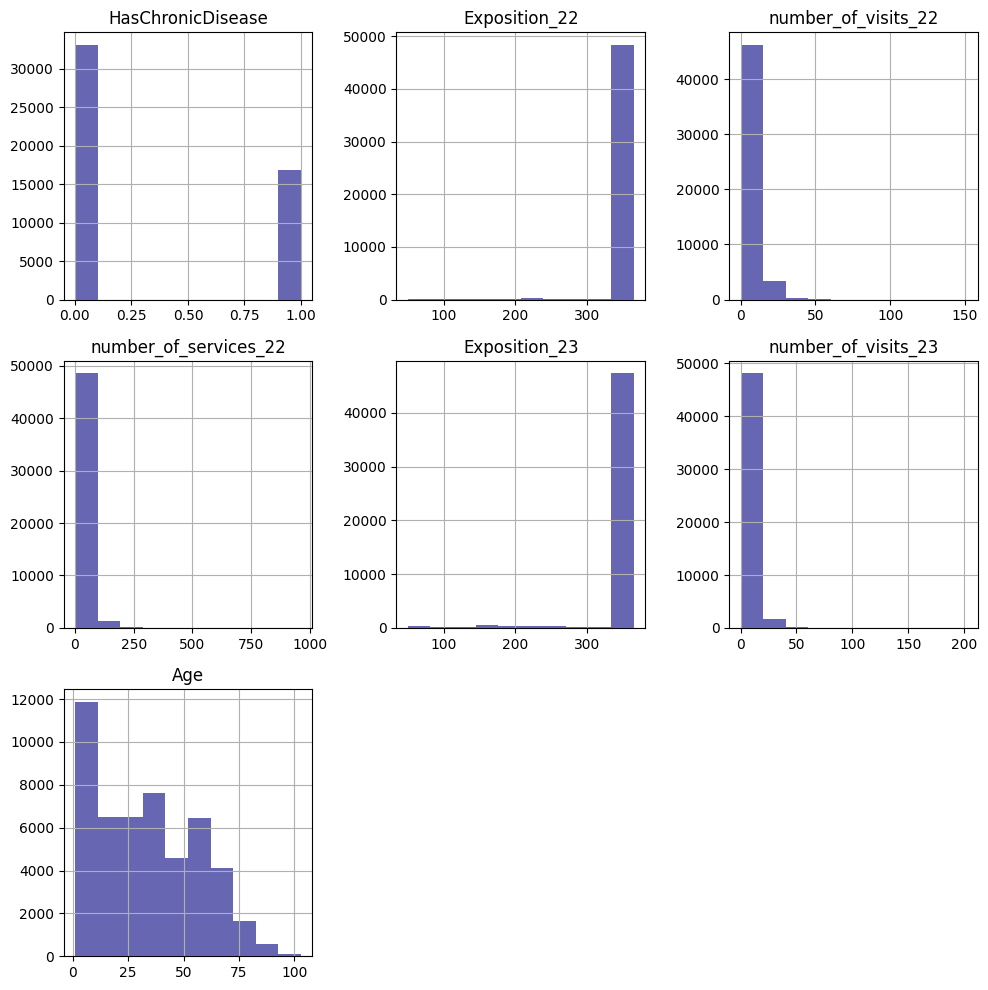

In [11]:
df_train.hist(figsize=(10, 10), color='navy', alpha = 0.6)
plt.tight_layout()
plt.show()

Смотрим медианное значение количества обращений пациентов в зависимости от принадлежности к разным группам.

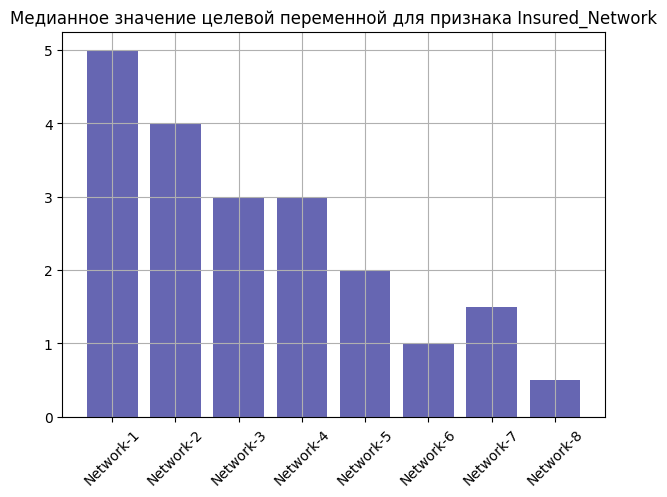

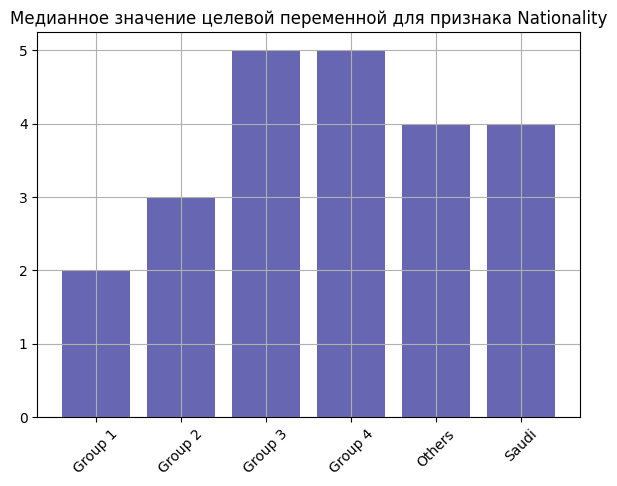

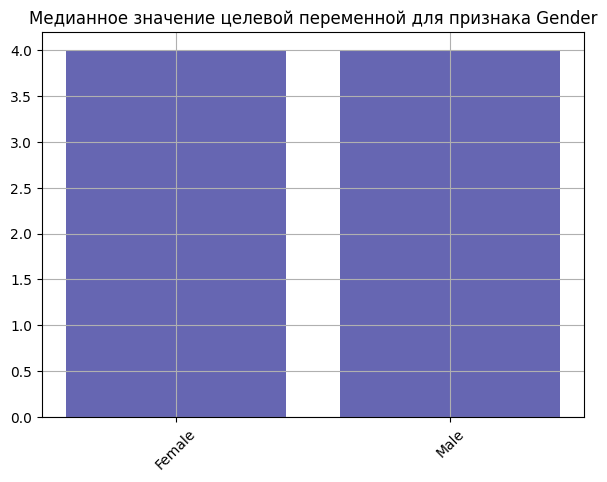

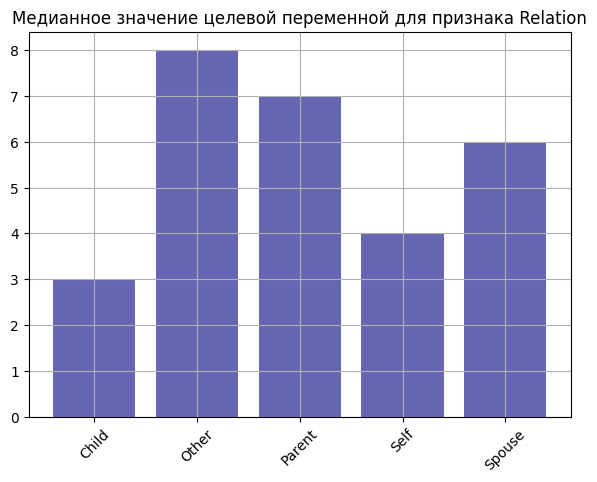

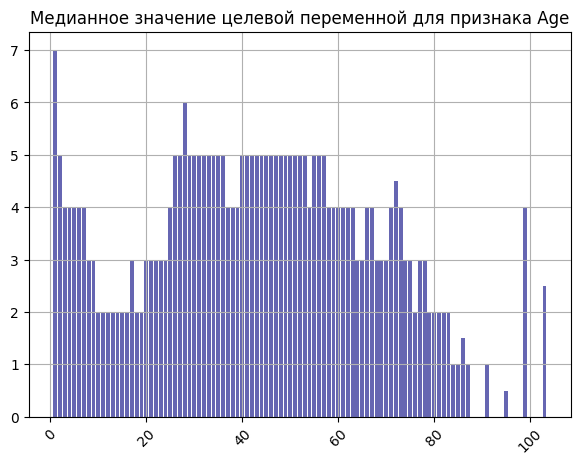

In [12]:
for feature in ['Insured_Network', 'Nationality', 'Gender', 'Relation', 'Age']:
  median_target_plot(feature)

Рисуем 'ящики с усами'.

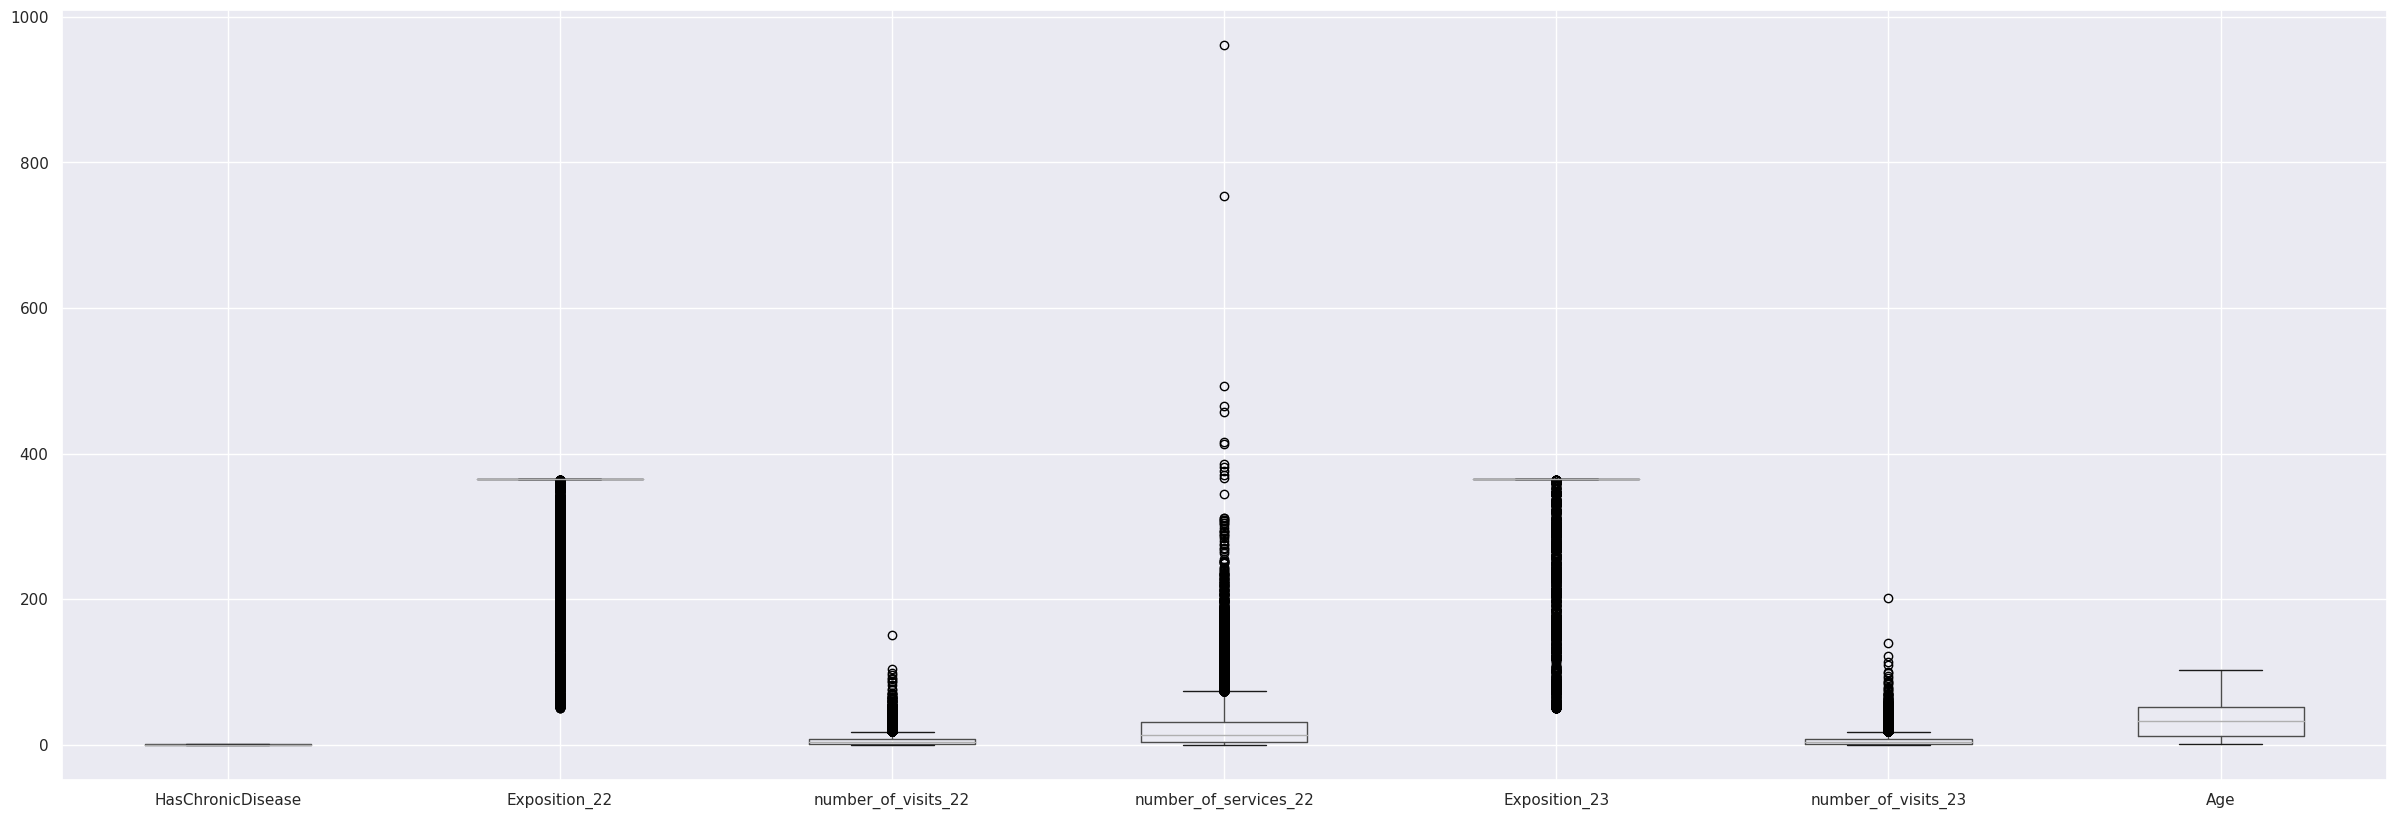

In [13]:
sns.set(rc={'figure.figsize': (30, 10)})
df_train.select_dtypes(include=np.number).boxplot();

Посмотрим, у кого было так много посещений клиники и полученных медицинских услуг.

In [14]:
df_train[df_train['number_of_visits_22']>100]

,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age
17292,Network-2,Saudi,Male,Self,R52.9;K29.1;E13.52;M54.5;E10.42;I87.2;I95.9;A4...,1,365,151,962,365,202,77.0
19620,Network-2,Saudi,Male,Self,G62.9;E27.3;E11;E03;H16.0;M79.66;R06.0;M25.5;J...,0,365,104,754,365,140,45.0


In [15]:
df_train[df_train['number_of_visits_23']>100]

,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age
4275,Network-2,Saudi,Male,Self,K29;J02;R05;A04.9;A08.4;R50;R51;J03;J00;R10;K2...,1,365,55,97,365,122,36.0
7247,Network-2,Saudi,Female,Self,R11;J06;N18;R06.0;N18.5;R10.4;Z49.1;I52;R07.4;...,0,365,10,104,365,114,76.0
8464,Network-2,Saudi,Female,Self,E11;B07;M17.0;E55;E78;K21;A09.9;E78.5;M17,0,365,16,72,365,109,57.0
17292,Network-2,Saudi,Male,Self,R52.9;K29.1;E13.52;M54.5;E10.42;I87.2;I95.9;A4...,1,365,151,962,365,202,77.0
19620,Network-2,Saudi,Male,Self,G62.9;E27.3;E11;E03;H16.0;M79.66;R06.0;M25.5;J...,0,365,104,754,365,140,45.0


In [16]:
df_train[df_train['number_of_services_22']>200]

,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age
146,Network-2,Saudi,Female,Spouse,I10;M48.89;E05.0;H10.5;M75.1;H10.1;H61.2;L10;E...,1,365,37,234,365,45,58.0
371,Network-2,Saudi,Male,Self,M75.4;M25.5;A09.0;M25.50;S43.4;M75.1;K62.5;R06...,1,365,42,274,365,7,46.0
408,Network-2,Saudi,Female,Self,J45;J18.9;B34.2;A41.9;Z10;J96.0;M33.2;UNKRC;H9...,1,365,43,236,365,77,71.0
429,Network-2,Saudi,Female,Self,H10.8;K76.0;E11;N76.0;M25.50;M81;R23;T14;N77.1...,1,365,15,220,365,0,70.0
561,Network-2,Saudi,Male,Self,J32;R10.4;H04;K58.9;K58;J02;M60.9;L25;M25.5;R1...,1,365,46,206,365,36,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
47772,Network-2,Saudi,Female,Self,E04.9;M76.7;E04.0;T81.41;Z47.9;M25.57;J30;G44;...,1,365,41,241,365,17,38.0
48666,Network-1,Saudi,Female,Parent,J30;M54.5;K29.5;N30;R30.0;Z47;M47;Z01.0;K59.0;...,1,365,38,207,365,31,84.0
48736,Network-1,Saudi,Male,Parent,M25.5;E11;F32;M17;R50.9;I20.0;R05;R10.4;R53;H9...,1,365,33,253,365,28,80.0
49392,Network-1,Saudi,Male,Self,E11.42;M50.0;POM;E11.40;R60;M50.9;I10;M25.66;S...,1,365,34,238,50,7,40.0


## Выводы по разделу.
- Пропуски в данных обработаны.
- На основе даты рождения застрахованных был создан более информативный признак - их возраст.
- Данные готовы к машинному обучению.
- В данных самой представленной возрастной группой являются дети.
- Людей без хронических заболеваний в данных почти в 2 раза больше, чем с таковыми.
- По медианным значениям количества обращений в 23-м году лидируют клиники с наивысшим уровнем сервиса, группы национальностей 3 и 4, группа застрахованных Other и дети-груднички. Здесь можно выдвинуть предположение о том, что люди, платящие большие деньги за максимально возможное количество медицинских услуг, не упускают возможность лишний раз обратиться ко врачу, а новорождённые дети требуют постоянного врачебного контроля. Половая принадлежность застрахованного на величину медианного количества обращений не влияет.
- В данных есть выбросы, но признаки, в которых они имеют место быть, наводят на мысль, что это вполне могут быть реальные данные: например, каждая медицинская услуга идёт в статистике отдельным пунктом и для человека, регулярно обращающегося ко врачам, действительно их общее количество может за год приблизиться к тысяче. Очень большое количество обращений в клинику в год, судя по данным, у людей с большим количеством медицинских диагнозов, так что тоже допустим это в качестве истинного значения.

# Корреляции.

Посмотрим корреляции входных параметров и таргета. Используем для этого библиотеку Phik, которая работает и с категориальными фичами.

interval columns not set, guessing: ['HasChronicDisease', 'Exposition_22', 'number_of_visits_22', 'number_of_services_22', 'Exposition_23', 'number_of_visits_23', 'Age']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Diagnoses is large: 35467. Are you sure this is not an interval variable? Analysis for pairs of variables including Diagnoses can be slow.
  warnings.warn(


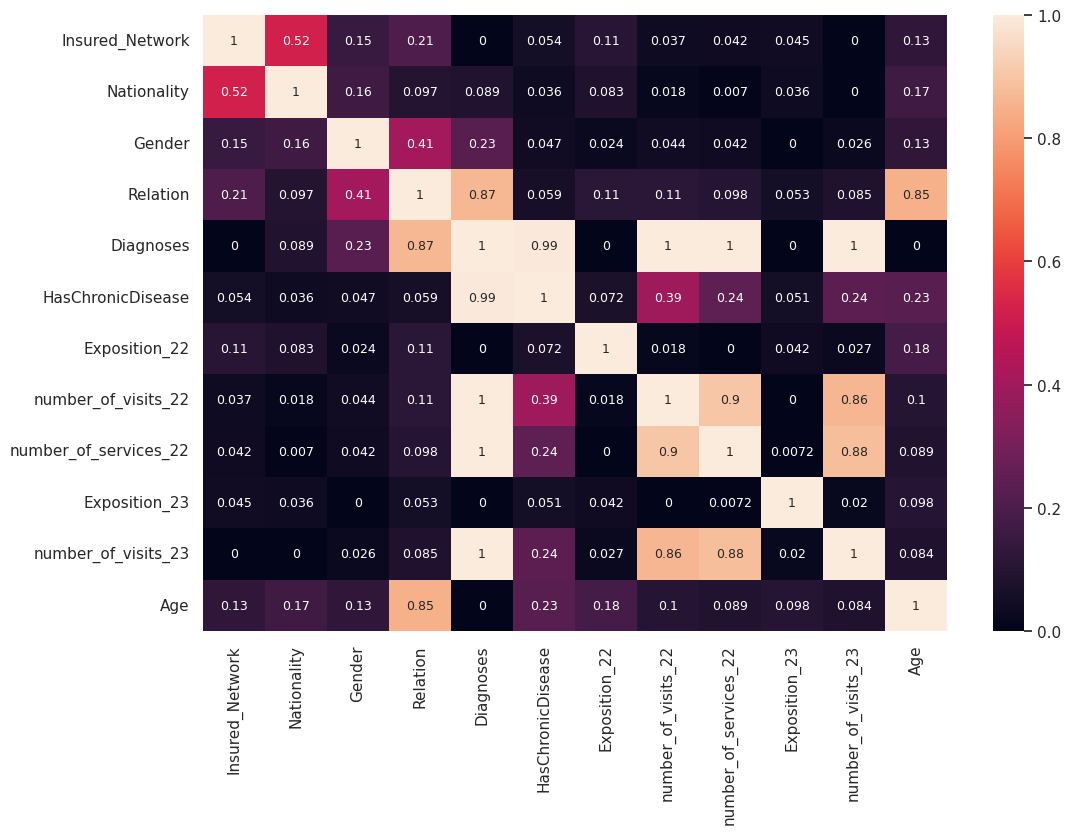

In [17]:
df_phik = df_train.copy()
phik_overview = df_phik.phik_matrix()

plt.figure(figsize=(12, 8))
sns.heatmap(phik_overview, annot=True, annot_kws={'fontsize': 9})
plt.show()

## Выводы по разделу.
- Больше половины входящих признаков, судя по корреляциям, не имеют влияния на таргет. Впрочем, признаков у нас и так не особо много, поэтому пока не спешим их удалять, посмотрим, что покажут feature importances модели.

# Машинное обучение на тренировочной выборке.

В качестве модели машинного обучения будем использовать CatBoost, т. к. она стабильно показывает хорошие результаты, умеет самостоятельно обрабатывать категориальные фичи и делать стандартизацию числовых. Устроим кросс-валидацию на тренировочных данных, посмотрим результаты.

In [18]:
model_cb = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=['Insured_Network', 'Nationality', 'Gender', 'Relation', 'Diagnoses'],
    random_seed=RNDM_STATE,
)

# Разбиение данных на фолды для кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=RNDM_STATE)

# Создание списка для сохранения метрик качества модели на каждом фолде
metrics = []

# Цикл по каждому фолду
for train_index, test_index in kfold.split(df_train):
    # Разделение данных на обучающие и тестовые наборы
    X_train, X_test = df_train.iloc[train_index].drop(
        ['number_of_visits_23'], axis=1
    ), df_train.iloc[test_index].drop(['number_of_visits_23'], axis=1)
    y_train, y_test = (
        df_train.iloc[train_index]['number_of_visits_23'],
        df_train.iloc[test_index]['number_of_visits_23'],
    )

    # Обучение модели
    model_cb.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        early_stopping_rounds=50,
    )

    # Прогнозирование на тестовом наборе и вычисление метрики качества
    y_pred = model_cb.predict(X_test)
    metric = mean_squared_error(y_test, y_pred)
    metrics.append(metric)

# Вывод средней метрики качества на всех фолдах
print('Среднее MSE на кросс-валидации:', np.mean(metrics))

0:	learn: 6.6180832	test: 6.4049089	best: 6.4049089 (0)	total: 105ms	remaining: 1m 44s
100:	learn: 4.7742419	test: 4.7514692	best: 4.7514686 (99)	total: 4.17s	remaining: 37.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.746641791
bestIteration = 147

Shrink model to first 148 iterations.
0:	learn: 6.5944172	test: 6.5308316	best: 6.5308316 (0)	total: 46.8ms	remaining: 46.7s
100:	learn: 4.8080718	test: 4.7545061	best: 4.7545061 (100)	total: 6.18s	remaining: 55s
200:	learn: 4.7151021	test: 4.7308437	best: 4.7307293 (196)	total: 10.7s	remaining: 42.4s
300:	learn: 4.6615304	test: 4.7176950	best: 4.7172889 (276)	total: 15s	remaining: 34.9s
400:	learn: 4.6161412	test: 4.7182697	best: 4.7141545 (367)	total: 22.1s	remaining: 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.714154487
bestIteration = 367

Shrink model to first 368 iterations.
0:	learn: 6.5047279	test: 6.8300529	best: 6.8300529 (0)	total: 45.8ms	remaining: 45.7s
100:	learn: 4.7231442	

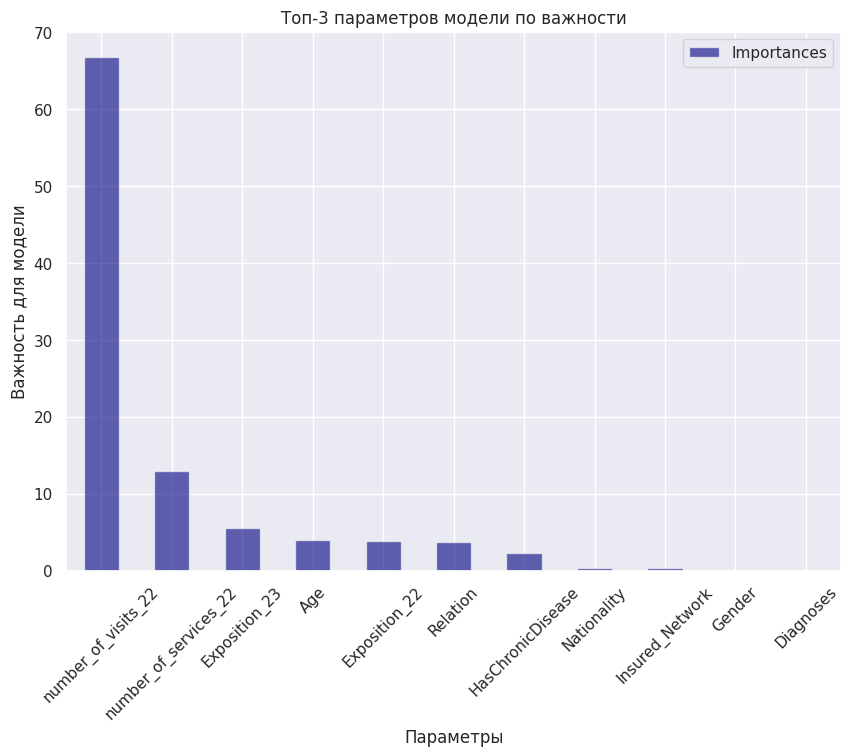

In [19]:
feature_imp(model_cb)

## Выводы по разделу.
- CatBoost, обученный на полном наборе признаков, даёт на кросс-валидации значение метрики MSE 23,469.
- Самым важным признаком для модели стало количество визитов застрахованного в клинику в предыдущем году.
- Диагнозы, пол, национальность и страховая сеть клиентов на результат работы модели практически не влияют.
- Попробуем улучшить модель путём удаления незначительных признаков.

# Доработка модели.

Поэтапно будем удалить по признаку, для этого каждый раз будем создавать копию данных, дабы в случае неудачи была возможность вернуться назад.

In [20]:
df_train_2 = df_train.copy()

In [21]:
df_train_2.drop(columns=['Diagnoses'], inplace=True)

In [22]:
model_cb_2 = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=['Insured_Network', 'Nationality', 'Gender', 'Relation'],
    random_seed=RNDM_STATE,
)

kfold = KFold(n_splits=10, shuffle=True, random_state=RNDM_STATE)

metrics = []

for train_index, test_index in kfold.split(df_train_2):
    X_train, X_test = df_train_2.iloc[train_index].drop(
        ['number_of_visits_23'], axis=1
    ), df_train_2.iloc[test_index].drop(['number_of_visits_23'], axis=1)
    y_train, y_test = (
        df_train_2.iloc[train_index]['number_of_visits_23'],
        df_train_2.iloc[test_index]['number_of_visits_23'],
    )

    model_cb_2.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        early_stopping_rounds=50,
    )

    y_pred = model_cb_2.predict(X_test)
    metric = mean_squared_error(y_test, y_pred)
    metrics.append(metric)

print('Среднее MSE на кросс-валидации:', np.mean(metrics))

0:	learn: 6.6004749	test: 6.4166131	best: 6.4166131 (0)	total: 39.2ms	remaining: 39.2s
100:	learn: 4.7577622	test: 4.7397855	best: 4.7386975 (97)	total: 3.87s	remaining: 34.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.733789541
bestIteration = 118

Shrink model to first 119 iterations.
0:	learn: 6.6015440	test: 6.4091053	best: 6.4091053 (0)	total: 36ms	remaining: 35.9s
100:	learn: 4.7641770	test: 4.7589971	best: 4.7589966 (98)	total: 2.88s	remaining: 25.7s
200:	learn: 4.6780237	test: 4.7515436	best: 4.7497344 (171)	total: 8.44s	remaining: 33.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.749734416
bestIteration = 171

Shrink model to first 172 iterations.
0:	learn: 6.5863807	test: 6.5490519	best: 6.5490519 (0)	total: 35.8ms	remaining: 35.8s
100:	learn: 4.7696771	test: 4.7198577	best: 4.7197946 (99)	total: 2.77s	remaining: 24.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.717765337
bestIteration = 116

Shrink mode

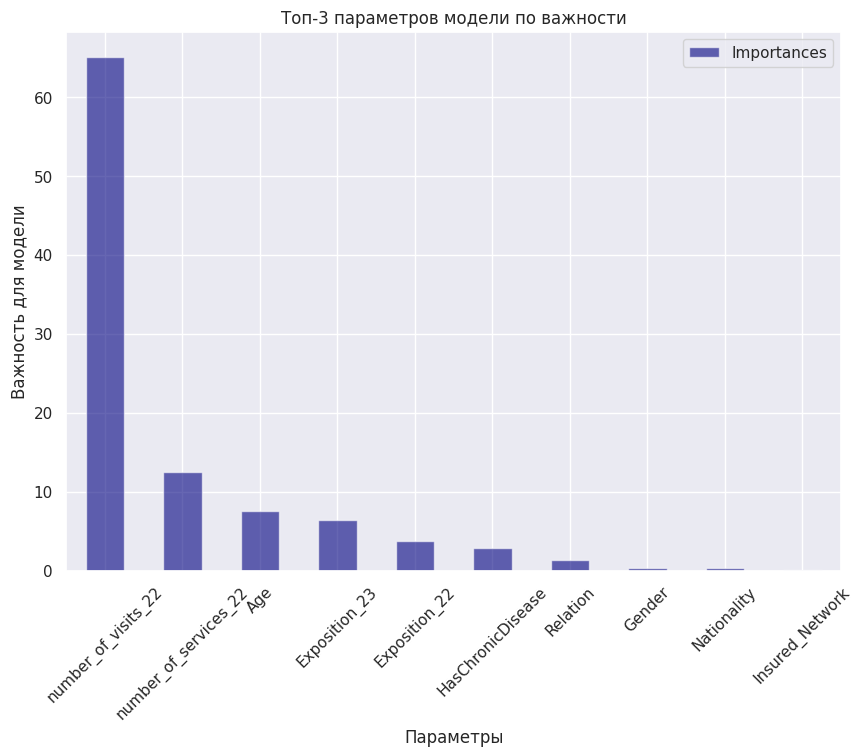

In [23]:
feature_imp(model_cb_2)

In [24]:
df_train_3 = df_train_2.copy()

In [25]:
df_train_3.drop(columns=['Nationality'], inplace=True)

In [26]:
model_cb_3 = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=['Insured_Network', 'Gender', 'Relation'],
    random_seed=RNDM_STATE,
)

kfold = KFold(n_splits=5, shuffle=True, random_state=RNDM_STATE)

metrics = []


for train_index, test_index in kfold.split(df_train_2):
    X_train, X_test = df_train_3.iloc[train_index].drop(
        ['number_of_visits_23'], axis=1
    ), df_train_3.iloc[test_index].drop(['number_of_visits_23'], axis=1)
    y_train, y_test = (
        df_train_3.iloc[train_index]['number_of_visits_23'],
        df_train_3.iloc[test_index]['number_of_visits_23'],
    )

    model_cb_3.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        early_stopping_rounds=50,
    )

    y_pred = model_cb_3.predict(X_test)
    metric = mean_squared_error(y_test, y_pred)
    metrics.append(metric)

print('Среднее MSE на кросс-валидации:', np.mean(metrics))

0:	learn: 6.6130206	test: 6.4020960	best: 6.4020960 (0)	total: 20.8ms	remaining: 20.7s
100:	learn: 4.7582431	test: 4.7385629	best: 4.7381588 (97)	total: 3.89s	remaining: 34.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.734739434
bestIteration = 117

Shrink model to first 118 iterations.
0:	learn: 6.5845127	test: 6.5300447	best: 6.5300447 (0)	total: 21.4ms	remaining: 21.4s
100:	learn: 4.7917442	test: 4.7560571	best: 4.7548134 (98)	total: 1.82s	remaining: 16.2s
200:	learn: 4.6971603	test: 4.7284208	best: 4.7272273 (192)	total: 3.9s	remaining: 15.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.725669051
bestIteration = 234

Shrink model to first 235 iterations.
0:	learn: 6.5042055	test: 6.8249598	best: 6.8249598 (0)	total: 21.3ms	remaining: 21.2s
100:	learn: 4.7022319	test: 5.0681862	best: 5.0681862 (100)	total: 1.92s	remaining: 17.1s
200:	learn: 4.6277351	test: 5.0455078	best: 5.0451504 (188)	total: 4.08s	remaining: 16.2s
Stopped by overfit

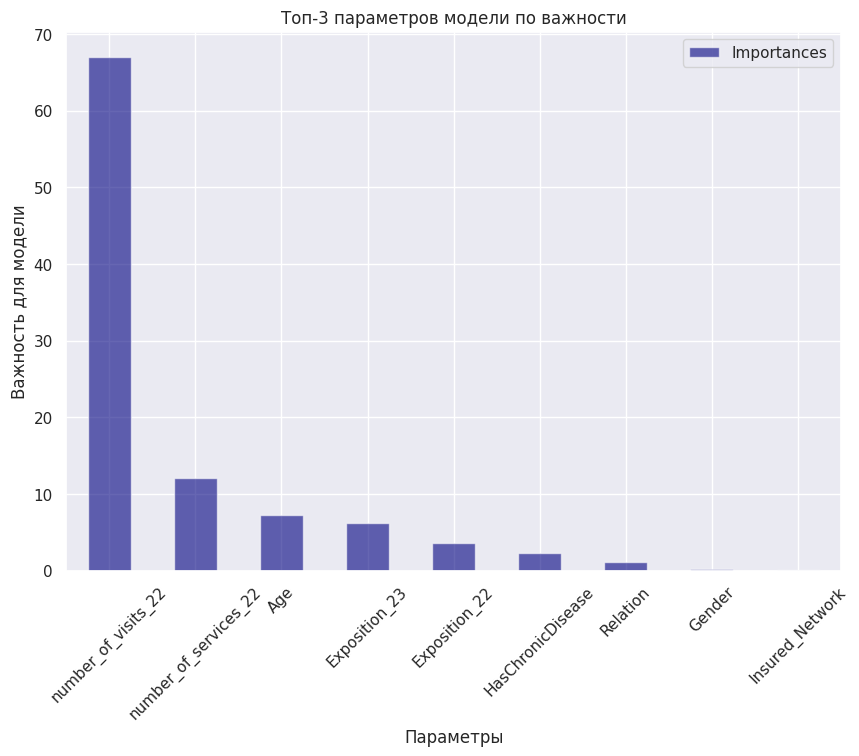

In [27]:
feature_imp(model_cb_3)

In [28]:
df_train_4 = df_train_3.copy()

In [29]:
df_train_4.drop(columns=['Insured_Network'], inplace=True)

In [30]:
model_cb_4 = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=['Gender', 'Relation'],
    random_seed=RNDM_STATE,
)

kfold = KFold(n_splits=5, shuffle=True, random_state=RNDM_STATE)

metrics = []

for train_index, test_index in kfold.split(df_train_4):
    X_train, X_test = df_train_4.iloc[train_index].drop(
        ['number_of_visits_23'], axis=1
    ), df_train_4.iloc[test_index].drop(['number_of_visits_23'], axis=1)
    y_train, y_test = (
        df_train_4.iloc[train_index]['number_of_visits_23'],
        df_train_4.iloc[test_index]['number_of_visits_23'],
    )

    model_cb_4.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

    y_pred = model_cb_4.predict(X_test)
    metric = mean_squared_error(y_test, y_pred)
    metrics.append(metric)

print('Среднее MSE на кросс-валидации:', np.mean(metrics))

0:	learn: 6.6099247	test: 6.3948672	best: 6.3948672 (0)	total: 15.8ms	remaining: 15.8s
100:	learn: 4.7563361	test: 4.7567091	best: 4.7563665 (98)	total: 1.43s	remaining: 12.7s
200:	learn: 4.6673894	test: 4.7664592	best: 4.7547083 (103)	total: 2.87s	remaining: 11.4s
300:	learn: 4.6074467	test: 4.7794956	best: 4.7547083 (103)	total: 5.63s	remaining: 13.1s
400:	learn: 4.5658213	test: 4.7921428	best: 4.7547083 (103)	total: 8.67s	remaining: 13s
500:	learn: 4.5268016	test: 4.8003623	best: 4.7547083 (103)	total: 10.2s	remaining: 10.2s
600:	learn: 4.4959373	test: 4.8105304	best: 4.7547083 (103)	total: 11.8s	remaining: 7.82s
700:	learn: 4.4705918	test: 4.8159160	best: 4.7547083 (103)	total: 13.3s	remaining: 5.68s
800:	learn: 4.4446474	test: 4.8224417	best: 4.7547083 (103)	total: 14.8s	remaining: 3.69s
900:	learn: 4.4191118	test: 4.8308854	best: 4.7547083 (103)	total: 16.4s	remaining: 1.8s
999:	learn: 4.3981165	test: 4.8386562	best: 4.7547083 (103)	total: 17.9s	remaining: 0us

bestTest = 4.75470

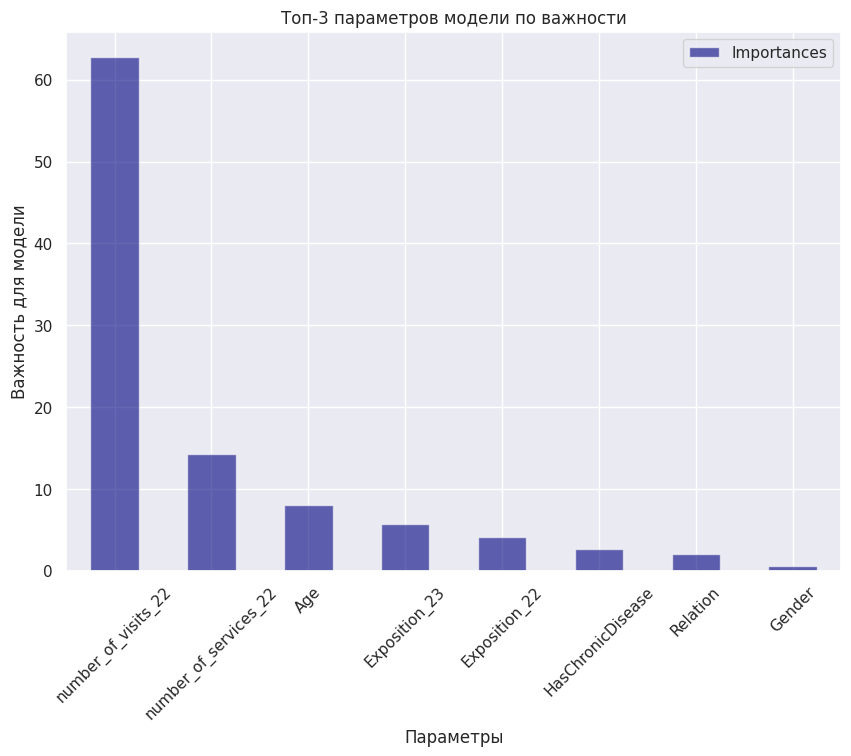

In [31]:
feature_imp(model_cb_4)

## Выводы по разделу.
- Повышения значения метрики путём удаления части признаков так и не удалось добиться, поэтому возвращаемся к исходным данным, будем обучать модель на всех признаках, какие у нас есть.

# Обучение на тестовой выборке.

Ещё раз посмотрим на тестовые данные.

In [32]:
df_info(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Insured_PIN            10000 non-null  int64 
 1   Insured_Network        10000 non-null  object
 2   Nationality            10000 non-null  object
 3   Gender                 10000 non-null  object
 4   Relation               10000 non-null  object
 5   Diagnoses              10000 non-null  object
 6   HasChronicDisease      10000 non-null  int64 
 7   Exposition_22          10000 non-null  int64 
 8   number_of_visits_22    10000 non-null  int64 
 9   number_of_services_22  10000 non-null  int64 
 10  Exposition_23          10000 non-null  int64 
 11  Age                    10000 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 937.6+ KB
None



,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age
5595,1339307,Network-2,Saudi,Female,Child,A09.0;K29.7,0,365,1,5,365,8
1684,1487509,Network-2,Saudi,Female,Spouse,M54.5,0,365,1,6,365,30
2705,1643527,Network-2,Saudi,Male,Child,J20;J03.9,0,365,2,17,365,5
6038,42077770,Network-5,Group 2,Male,Self,I25.9;K29.7;E78.2;I10;E11.40;I25;E78.5;G60.3;E11,1,365,4,60,365,60
9402,1376482,Network-2,Saudi,Female,Self,unknown,0,365,0,0,365,58
878,2369255,Network-2,Saudi,Female,Child,R69;J45;J20;T78.4,0,365,3,12,365,4
4334,1367830,Network-2,Saudi,Female,Self,H04.1;M65.4;E78.5;I10;I11;N39.81,1,365,8,57,365,76
139,16912473,Network-5,Group 2,Male,Self,J20.9;J06.9;I10;L08.0;J30.4;E78.2,1,365,14,53,365,55
2712,1529298,Network-2,Saudi,Male,Self,N21.9;D51.9;K64.9;K62.6;L72.0;J00;N39.0;L02.9;...,0,365,9,39,365,55
1794,1355230,Network-2,Saudi,Female,Child,A09.9;J03;J00;T78.4,1,365,5,11,365,5


,Insured_PIN,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5.321900e+06,0.338000,359.426100,5.823600,22.991300,355.038600,33.41460
std,1.487940e+07,0.473052,33.756826,6.789425,30.820412,45.307745,22.70475
min,6.366500e+04,0.000000,50.000000,0.000000,0.000000,50.000000,1.00000
25%,1.394638e+06,0.000000,365.000000,1.000000,3.000000,365.000000,12.00000
50%,1.457448e+06,0.000000,365.000000,4.000000,13.000000,365.000000,32.00000
75%,1.622645e+06,1.000000,365.000000,8.000000,31.000000,365.000000,53.00000
max,9.105157e+07,1.000000,365.000000,113.000000,495.000000,365.000000,101.00000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
Insured_PIN,0.000000
Insured_Network,0.000000
Nationality,0.000000
Gender,0.000000
Relation,0.000000
Diagnoses,0.000000
HasChronicDisease,0.000000
Exposition_22,0.000000
number_of_visits_22,0.000000
number_of_services_22,0.000000


Вынесем уникальные номеры застрахованных в отдельную переменную, после чего удалим из данных.

In [33]:
ids = df_test['Insured_PIN']
df_test.drop(columns=['Insured_PIN'], inplace=True)

На тестовых данных мы использовали кросс-валидацию, теперь просто обучим модель на них целиком и получим предсказания.

In [34]:
X_train = df_train.drop('number_of_visits_23', axis=1)
y_train = df_train['number_of_visits_23']

model_cb.fit(X_train, y_train)

predictions = model_cb.predict(df_test)

0:	learn: 6.5770491	total: 52.4ms	remaining: 52.3s
1:	learn: 6.3372189	total: 110ms	remaining: 54.9s
2:	learn: 6.1294861	total: 162ms	remaining: 53.7s
3:	learn: 5.9574834	total: 214ms	remaining: 53.4s
4:	learn: 5.8017805	total: 263ms	remaining: 52.3s
5:	learn: 5.6736458	total: 311ms	remaining: 51.5s
6:	learn: 5.5588394	total: 362ms	remaining: 51.3s
7:	learn: 5.4672453	total: 411ms	remaining: 51s
8:	learn: 5.3837826	total: 465ms	remaining: 51.2s
9:	learn: 5.3099850	total: 520ms	remaining: 51.5s
10:	learn: 5.2484606	total: 568ms	remaining: 51.1s
11:	learn: 5.1997815	total: 615ms	remaining: 50.6s
12:	learn: 5.1577236	total: 679ms	remaining: 51.6s
13:	learn: 5.1159370	total: 732ms	remaining: 51.6s
14:	learn: 5.0832936	total: 783ms	remaining: 51.4s
15:	learn: 5.0541773	total: 834ms	remaining: 51.3s
16:	learn: 5.0276417	total: 891ms	remaining: 51.5s
17:	learn: 5.0037243	total: 942ms	remaining: 51.4s
18:	learn: 4.9837946	total: 984ms	remaining: 50.8s
19:	learn: 4.9650648	total: 1.03s	remainin

Смотрим, что получилось.

In [35]:
predictions

array([ 2.03890858,  5.28861826,  5.75691202, ...,  3.53801631,
        1.80701099, 26.65481952])

Количество визитов - число целое, так что округлим предсказанные значения, после чего занесём их в таблицу.

In [36]:
predictions_int = [round(num) for num in predictions]
predictions_df =  pd.DataFrame(predictions_int)

Объединим номера застрахованных и предсказания для них, после чего сохраним всё в выходной файл.

In [37]:
combined_table = pd.concat([ids, predictions_df], axis=1)
combined_table = combined_table.rename(columns={0: 'number_of_visits_23'})
combined_table.to_csv('output.csv', index=False)
combined_table

,Insured_PIN,number_of_visits_23
0,1516424,2
1,22210474,5
2,1518945,6
3,1344077,7
4,1354276,5
...,...,...
9995,3948786,9
9996,67038285,11
9997,1371592,4
9998,62818434,2


## Выводы по разделу.
- Наилучшая из наших моделей обучена на полном наборе тренировочных данных и дала предсказания.
- Результаты предсказаний округлены до целых чисел и занесены в csv-файл.

# Выводы по работе.
- Данные были загружены, изучены и подготовлены к машинному обучению.
- Были построены графики.
- Рассмотрены корреляции признаков в тренировочном датафрейме.
- Машинное обучение выполнялось с помощью модели CatBoost Regressor.
- На тренировочных данных с помощью кросс-валидации достигнуто значение метрики MSE 23,469 у модели, обученной на всех признаках из исходного набора данных.
- Выполнено предсказание на тестовых данных, результаты собраны в файл output.csv.